In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

data = pd.read_csv('train_hsbc_df.csv')

print("Data Overview:")
print(data.info())

print("\nFirst Few Rows:")
print(data.head())

print("\nMissing Values:")
print(data.isnull().sum())


Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513643 entries, 0 to 513642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         513643 non-null  int64  
 1   customer     513643 non-null  object 
 2   age          513643 non-null  object 
 3   gender       513643 non-null  object 
 4   zipcodeOri   513643 non-null  object 
 5   merchant     513643 non-null  object 
 6   zipMerchant  513643 non-null  object 
 7   category     513643 non-null  object 
 8   amount       513643 non-null  float64
 9   fraud        513643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 39.2+ MB
None

First Few Rows:
   step       customer  age gender zipcodeOri       merchant zipMerchant  \
0     0   'C583110837'  '3'    'M'    '28007'   'M480139044'     '28007'   
1     0  'C1332295774'  '3'    'M'    '28007'   'M480139044'     '28007'   
2     0  'C1160421902'  '3'    'M'    '28007'

Data Preprocessing

In [ ]:
categorical_columns = ['gender', 'zipcodeOri', 'merchant', 'zipMerchant', 'category']
numerical_columns = ['step', 'amount']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())]),
         numerical_columns),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))]),
         categorical_columns)
    ])

X = data.drop(columns=['fraud'])
y = data['fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)


Model Training and Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(estimator=LogisticRegression(random_state=42, max_iter=10000),
                           param_grid=param_grid,
                           scoring='f1',
                           cv=2,
                           verbose=1,
                           n_jobs=-1)


grid_search.fit(X_train_smote, y_train_smote)


best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

y_prob = best_model.predict_proba(X_test_preprocessed)[:, 1]
y_pred_lr = best_model.predict(X_test_preprocessed)


Fitting 2 folds for each of 24 candidates, totalling 48 fits
Best Parameters: {'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}


Model Evaluation

In [ ]:
from sklearn.metrics import precision_recall_curve, accuracy_score

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

f1_scores = 2 * (precision * recall) / (precision + recall)

best_threshold = thresholds[np.argmax(f1_scores)]

y_pred_adjusted = (y_prob >= best_threshold).astype(int)

precision_score_adjusted = precision_score(y_test, y_pred_adjusted)
recall_score_adjusted = recall_score(y_test, y_pred_adjusted)
f1_adjusted = f1_score(y_test, y_pred_adjusted)
auc_roc = roc_auc_score(y_test, y_prob)
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)

print(f"Precision: {precision_score_adjusted:.4f}")
print(f"Recall: {recall_score_adjusted:.4f}")
print(f"F1 Score: {f1_adjusted:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Accuracy: {accuracy_adjusted:.4f}")


Precision: 0.8526
Recall: 0.7502
F1 Score: 0.7981
AUC-ROC: 0.9977
Accuracy: 0.9954


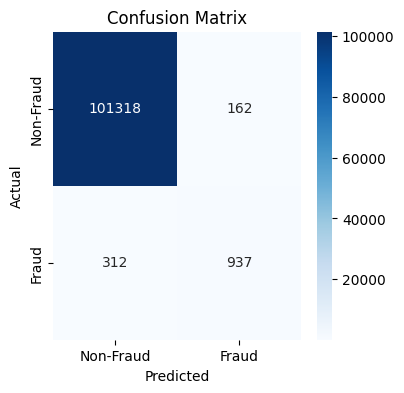

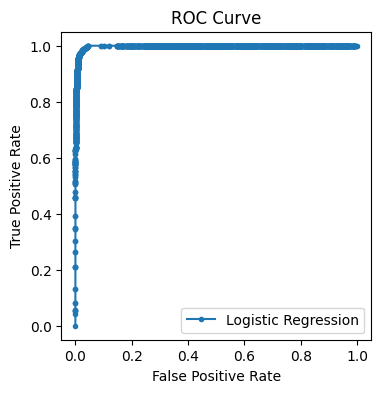

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, marker='.', label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


 Feature Importance Analysis

Feature Importance:
                         Feature  Coefficient  Abs_Coefficient
42         merchant_'M495352832'    -7.540828         7.540828
40          merchant_'M45060432'    -7.343441         7.343441
31        merchant_'M1946091778'    -6.976383         6.976383
12        merchant_'M1352454843'    -6.802670         6.802670
70  category_'es_transportation'    -6.768482         6.768482
..                           ...          ...              ...
63            category_'es_home'    -0.559048         0.559048
0                           step     0.351850         0.351850
4                     gender_'M'     0.309242         0.309242
20        merchant_'M1726401631'    -0.239850         0.239850
19        merchant_'M1649169323'    -0.039344         0.039344

[73 rows x 3 columns]

Top 10 Contributing Features:
                         Feature  Coefficient  Abs_Coefficient
42         merchant_'M495352832'    -7.540828         7.540828
40          merchant_'M45060432'    -7.34344

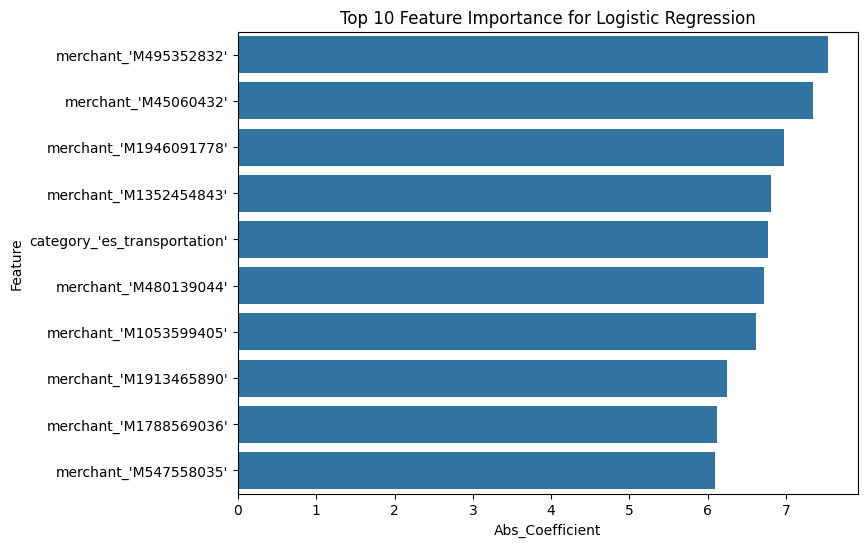

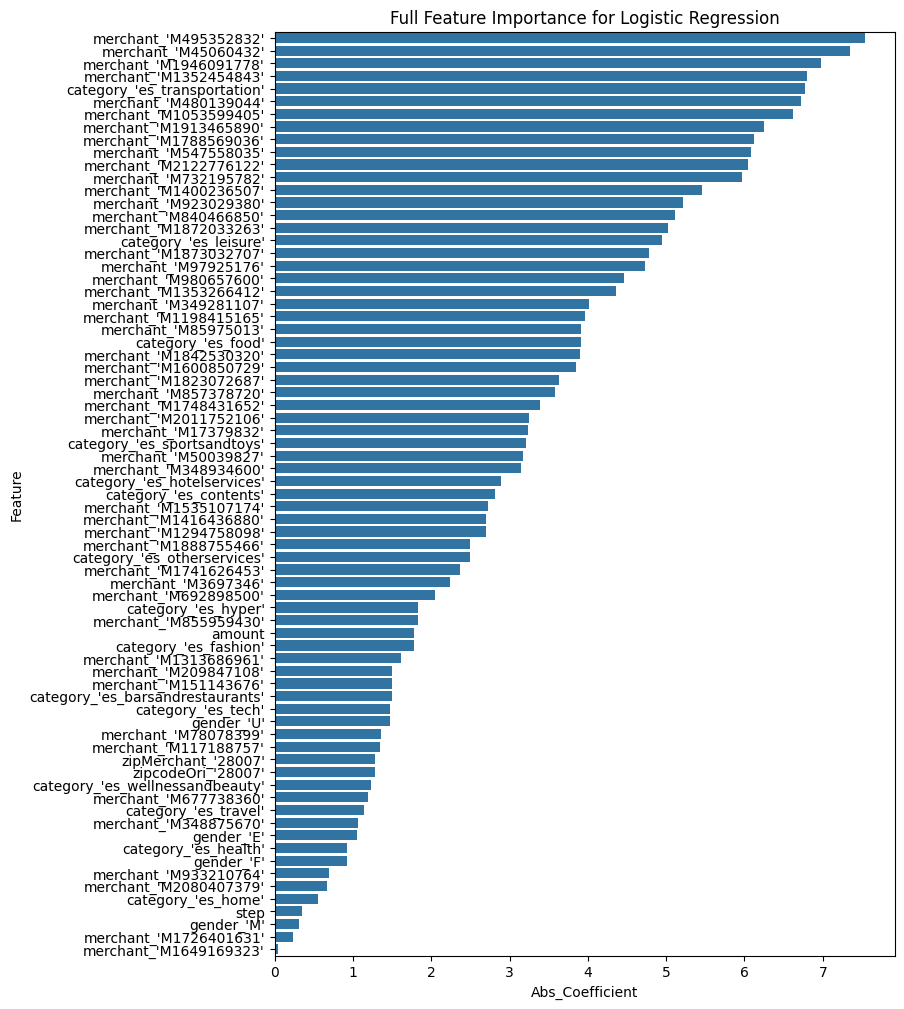


Top 5 Features with Positive Influence:
                   Feature  Coefficient  Abs_Coefficient
41   merchant_'M480139044'     6.716703         6.716703
44   merchant_'M547558035'     6.089643         6.089643
35  merchant_'M2122776122'     6.045869         6.045869
47   merchant_'M732195782'     5.972068         5.972068
53   merchant_'M923029380'     5.218573         5.218573

Top 5 Features with Negative Influence:
                         Feature  Coefficient  Abs_Coefficient
42         merchant_'M495352832'    -7.540828         7.540828
40          merchant_'M45060432'    -7.343441         7.343441
31        merchant_'M1946091778'    -6.976383         6.976383
12        merchant_'M1352454843'    -6.802670         6.802670
70  category_'es_transportation'    -6.768482         6.768482


In [ ]:
numerical_feature_names = numerical_columns

categorical_feature_names = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_columns)

feature_names = numerical_feature_names + list(categorical_feature_names)

coefficients = best_model.coef_[0]

if len(coefficients) == len(feature_names):
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    feature_importance_df['Abs_Coefficient'] = feature_importance_df['Coefficient'].abs()
    feature_importance_df = feature_importance_df.sort_values(by='Abs_Coefficient', ascending=False)

    print("Feature Importance:")
    print(feature_importance_df)

    top_features = feature_importance_df.head(10)
    print("\nTop 10 Contributing Features:")
    print(top_features)

    plt.figure(figsize=(8, 6))
    sns.barplot(x='Abs_Coefficient', y='Feature', data=top_features)
    plt.title('Top 10 Feature Importance for Logistic Regression')
    plt.show()

    plt.figure(figsize=(8, 12))
    sns.barplot(x='Abs_Coefficient', y='Feature', data=feature_importance_df)
    plt.title('Full Feature Importance for Logistic Regression')
    plt.show()

    positive_influence = feature_importance_df.sort_values(by='Coefficient', ascending=False).head(5)
    negative_influence = feature_importance_df.sort_values(by='Coefficient').head(5)

    print("\nTop 5 Features with Positive Influence:")
    print(positive_influence)

    print("\nTop 5 Features with Negative Influence:")
    print(negative_influence)

else:
    print("Error: The number of coefficients does not match the number of features.")


Additional Data Analysis

Summary Statistics for Numerical Features:
                step         amount
count  513643.000000  513643.000000
mean       94.992629      37.915481
std        51.063474     111.557455
min         0.000000       0.000000
25%        52.000000      13.740000
50%        97.000000      26.920000
75%       139.000000      42.550000
max       179.000000    7665.560000

Insights from Summary Statistics:
- step:
  - Mean: 94.99
  - Median: 97.00
  - Standard Deviation: 51.06
  - step has high variability, which may indicate outliers or diverse values.
- amount:
  - Mean: 37.92
  - Median: 26.92
  - Standard Deviation: 111.56
  - amount has high variability, which may indicate outliers or diverse values.

Distribution of gender:
gender
'F'    280199
'M'    231998
'E'      1009
'U'       437
Name: count, dtype: int64
  - Unique values: 4
  - gender is a low-cardinality feature, which is useful for one-hot encoding.

Distribution of zipcodeOri:
zipcodeOri
'28007'    513643
Name: count, dtype: i

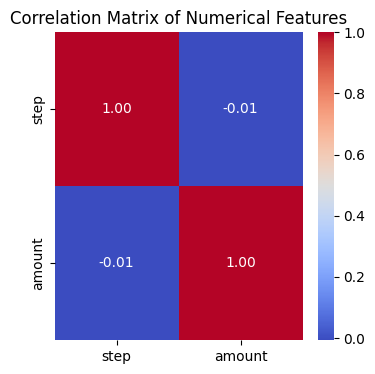


Insights from Correlation Matrix:
No highly correlated feature pairs detected.

Missing Values in Each Column:
Series([], dtype: int64)

Insights on Missing Values:
  - No missing values detected. The dataset is complete.


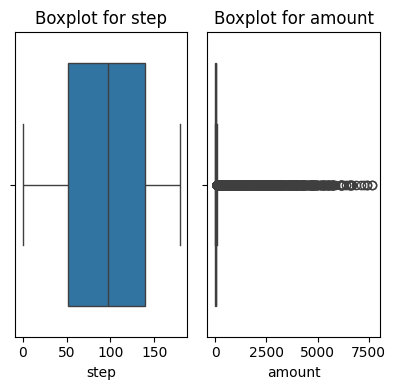


Insights on Outliers:
- step:
  - Outliers detected: 0
- amount:
  - Outliers detected: 22277


In [ ]:
print("Summary Statistics for Numerical Features:")
numerical_summary = X.describe()
print(numerical_summary)

print("\nInsights from Summary Statistics:")
for col in numerical_columns:
    print(f"- {col}:")
    print(f"  - Mean: {numerical_summary.at['mean', col]:.2f}")
    print(f"  - Median: {X[col].median():.2f}")
    print(f"  - Standard Deviation: {numerical_summary.at['std', col]:.2f}")
    if numerical_summary.at['std', col] > (numerical_summary.at['mean', col] * 0.5):
        print(f"  - {col} has high variability, which may indicate outliers or diverse values.")

for col in categorical_columns:
    print(f"\nDistribution of {col}:")
    print(X[col].value_counts())

    unique_vals = X[col].nunique()
    print(f"  - Unique values: {unique_vals}")
    if unique_vals < 10:
        print(f"  - {col} is a low-cardinality feature, which is useful for one-hot encoding.")
    elif unique_vals > 50:
        print(f"  - {col} is a high-cardinality feature, which may require special handling.")

plt.figure(figsize=(4, 4))
correlation_matrix = X[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

print("\nInsights from Correlation Matrix:")
high_correlation_pairs = []
for i in range(len(numerical_columns)):
    for j in range(i+1, len(numerical_columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_correlation_pairs.append((numerical_columns[i], numerical_columns[j], correlation_matrix.iloc[i, j]))

if high_correlation_pairs:
    print("Highly correlated pairs of features (correlation > 0.7):")
    for pair in high_correlation_pairs:
        print(f"  - {pair[0]} and {pair[1]}: {pair[2]:.2f}")
        print(f"    Consideration: These features may provide redundant information and could impact model performance.")
else:
    print("No highly correlated feature pairs detected.")

missing_values = data.isnull().sum()
print("\nMissing Values in Each Column:")
missing_values = missing_values[missing_values > 0]
print(missing_values)

print("\nInsights on Missing Values:")
if missing_values.empty:
    print("  - No missing values detected. The dataset is complete.")
else:
    for col, val in missing_values.items():
        print(f"  - {col} has {val} missing values ({(val/len(data)*100):.2f}% of total).")
        if val/len(data) > 0.1:
            print(f"    Consideration: Imputation or removal of {col} may be necessary as it has significant missing values.")

plt.figure(figsize=(4, 4))
for i, col in enumerate(numerical_columns):
    plt.subplot(1, len(numerical_columns), i+1)
    sns.boxplot(x=X[col])
    plt.title(f'Boxplot for {col}')
plt.tight_layout()
plt.show()

print("\nInsights on Outliers:")
for col in numerical_columns:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = X[(X[col] < (Q1 - 1.5 * IQR)) | (X[col] > (Q3 + 1.5 * IQR))]
    print(f"- {col}:")
    print(f"  - Outliers detected: {len(outliers)}")
